#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
df_stock1 = pd.read_csv("../static/data/nab.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT
0,3/01/2000,22.164883,22.164883,22.164883,22.164883,6.412319,0.0,NEGATIVE
1,4/01/2000,21.869984,21.879498,21.308727,21.403856,6.192155,3005390.0,NEGATIVE
2,5/01/2000,20.918701,21.099445,20.785522,20.975779,6.068309,4604126.0,NEGATIVE
3,6/01/2000,21.207891,21.213600,20.642830,20.642830,5.971987,2574906.0,POSITIVE
4,7/01/2000,20.737959,20.880651,20.623804,20.823574,6.024276,3028993.0,POSITIVE


<AxesSubplot:>

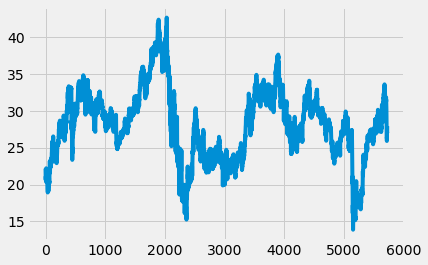

In [45]:
df["Close"].plot()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5692 entries, 0 to 5724
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5692 non-null   object 
 1   Open       5692 non-null   float64
 2   High       5692 non-null   float64
 3   Low        5692 non-null   float64
 4   Close      5692 non-null   float64
 5   Adj Close  5692 non-null   float64
 6   Volume     5692 non-null   float64
 7   SENTIMENT  5692 non-null   object 
dtypes: float64(6), object(2)
memory usage: 400.2+ KB


In [47]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5692, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [48]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4554, 1)

In [49]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.28791442, 0.26146737, 0.24659094, 0.23502037, 0.24130154,
       0.25154974, 0.23832627, 0.23270628, 0.22609451, 0.2418305 ,
       0.2783273 , 0.28956731, 0.27634378, 0.26232689, 0.24692153,
       0.26807911, 0.25419445, 0.25419445, 0.23802872, 0.2502274 ,
       0.23935106, 0.23766508, 0.24394619, 0.23164837, 0.23601218,
       0.24163217, 0.23832627, 0.24229329, 0.23964864, 0.23402862,
       0.2217969 , 0.2211688 , 0.2049369 , 0.19663915, 0.19204396,
       0.18708515, 0.17981223, 0.17551465, 0.17848986, 0.20496995,
       0.20526749, 0.22510273, 0.24844223, 0.25396308, 0.22649124,
       0.21022626, 0.22311917, 0.20625924, 0.18146513, 0.19138277,
       0.18410988, 0.19733342, 0.20526749, 0.21518516, 0.20625924,
       0.20715184, 0.21981334, 0.23733445, 0.23832627, 0.24179742])]
[0.22344979789408392]


# Prepare train data for LSTM model

In [50]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4494, 60)

In [51]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4494, 60, 1)

# Build the LSTM model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [53]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4494/4494 [==============================] - 70s 15ms/step - loss: 0.0012


In [55]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [56]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [57]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [58]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.164430621037381

C:\Users\antoi\AppData\Local\Temp/ipykernel_19312/1559395553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


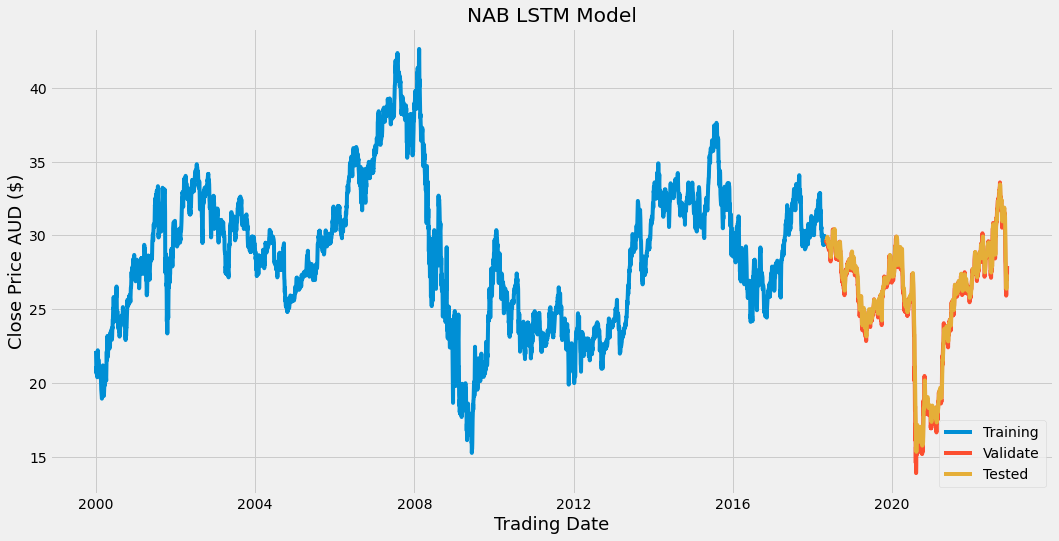

In [59]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NAB LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_graph.png')
plt.show()


# Test data Predictions on the Model

In [60]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_19312/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4587,29.559999,29.647541,-0.087542
4588,29.650000,29.647106,0.002894
4589,29.570000,29.704889,-0.134889
4590,29.570000,29.703096,-0.133096
4591,29.480000,29.694660,-0.214660
...,...,...,...
5720,27.049999,26.387690,0.662309
5721,26.990000,26.891087,0.098913
5722,27.129999,27.219231,-0.089232
5723,27.020000,27.422112,-0.402112


In [61]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB
db.nab.drop()

import csv
header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
csvfile = open('../static/data/nab.csv', 'r')
reader = csv.DictReader( csvfile )

for each in reader:
    row={}
    for field in header:
        row[field]=each[field]
        
    print (row)
    db.nab.insert_one(row)	

{'Date': '3/01/2000', 'Open': '22.164883', 'High': '22.164883', 'Low': '22.164883', 'Close': '22.164883', 'Adj Close': '6.412319', 'Volume': '0', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '4/01/2000', 'Open': '21.869984', 'High': '21.879498', 'Low': '21.308727', 'Close': '21.403856', 'Adj Close': '6.192155', 'Volume': '3005390', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '5/01/2000', 'Open': '20.918701', 'High': '21.099445', 'Low': '20.785522', 'Close': '20.975779', 'Adj Close': '6.068309', 'Volume': '4604126', 'SENTIMENT': 'NEGATIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '6/01/2000', 'Open': '21.207891', 'High': '21.2136', 'Low': '20.64283', 'Close': '20.64283', 'Adj Close': '5.971987', 'Volume': '2574906', 'SENTIMENT': 'POSITIVE', 'RBA': '5', 'FED': '5.5'}
{'Date': '7/01/2000', 'Open': '20.737959', 'High': '20.880651', 'Low': '20.623804', 'Close': '20.823574', 'Adj Close': '6.024276', 'Volume': '3028993', 'SENTIMENT': 'POSITIVE', 'RBA': '5', 'FED': '5

In [62]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'NAB.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [63]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [64]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [65]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 27


In [66]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED,CPI
5725,28/06/2022,28.02,28.049999,27.559999,27.790001,27.790001,4190622.0,NEGATIVE,0.85,1.75,125.0


In [67]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
print(actual_price,actual_date)


27 28/06/2022


# Save the Model

In [68]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nab_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list cba_sixty and load df

#PREDICT USING LOADED MODEL

In [69]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')

In [70]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
# create a connection to the sharesDb for the bhp collection
db_nab = client.sharesDB.nab

# query the bhp collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db_nab.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([['32.290001'],
       ['32.099998'],
       ['32.07'],
       ['32.049999'],
       ['31.959999'],
       ['32.200001'],
       ['32.330002'],
       ['32.490002'],
       ['32.779999'],
       ['32.779999'],
       ['32.849998'],
       ['32.880001'],
       ['33.18'],
       ['33.389999'],
       ['33.060001'],
       ['32.279999'],
       ['32.029999'],
       ['31.99'],
       ['32.3'],
       ['32'],
       ['31.93'],
       ['32.200001'],
       ['31.24'],
       ['31.5'],
       ['31.030001'],
       ['31.110001'],
       ['30.24'],
       ['30.379999'],
       ['30.65'],
       ['31.17'],
       ['31.110001'],
       ['31.129999'],
       ['30.700001'],
       ['30.75'],
       ['30.735001'],
       ['30.950001'],
       ['31.290001'],
       ['31.49'],
       ['31.540001'],
       ['31.51'],
       ['31.26'],
       ['31.42'],
       ['31.110001'],
       ['31.120001'],
       ['30.805'],
       ['30.059999'],
       ['28.84'],
       ['27.879999'],
       ['28.045'],
 

In [86]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# # Read in the CSV file
# nabdump_sixty = pd.read_csv("../static/data/nab.csv")
# nabdump_sixty = nabdump_sixty.dropna()
# nabdump_sixty = nabdump_sixty.iloc[-4250:]
# sixty_val = nabdump_sixty.iloc[-60:,4].values
# last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 100 #days
if input == "":
    input = 100
else:
   input = int(input)

def predict_nab(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [87]:
predict_nab(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [88]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [89]:
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_19312/2919172947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1, 'Date': '29/06/2022', 'DOW': 'Wednesday', 'Price': 27.88},
 {'Count': 2, 'Date': '30/06/2022', 'DOW': 'Thursday', 'Price': 27.98},
 {'Count': 3, 'Date': '1/07/2022', 'DOW': 'Friday', 'Price': 28.06},
 {'Count': 4, 'Date': '2/07/2022', 'DOW': 'Monday', 'Price': 28.11},
 {'Count': 5, 'Date': '3/07/2022', 'DOW': 'Tuesday', 'Price': 28.15},
 {'Count': 6, 'Date': '4/07/2022', 'DOW': 'Wednesday', 'Price': 28.18},
 {'Count': 7, 'Date': '5/07/2022', 'DOW': 'Thursday', 'Price': 28.2},
 {'Count': 8, 'Date': '6/07/2022', 'DOW': 'Friday', 'Price': 28.21},
 {'Count': 9, 'Date': '7/07/2022', 'DOW': 'Monday', 'Price': 28.22},
 {'Count': 10, 'Date': '8/07/2022', 'DOW': 'Tuesday', 'Price': 28.24},
 {'Count': 11, 'Date': '9/07/2022', 'DOW': 'Wednesday', 'Price': 28.25},
 {'Count': 12, 'Date': '10/07/2022', 'DOW': 'Thursday', 'Price': 28.26},
 {'Count': 13, 'Date': '11/07/2022', 'DOW': 'Friday', 'Price': 28.27},
 {'Count': 14, 'Date': '12/07/2022', 'DOW': 'Monday', 'Price': 28.29},
 {'Count

In [90]:
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 27.88},
 {'Price': 27.98},
 {'Price': 28.06},
 {'Price': 28.11},
 {'Price': 28.15},
 {'Price': 28.18},
 {'Price': 28.2},
 {'Price': 28.21},
 {'Price': 28.22},
 {'Price': 28.24},
 {'Price': 28.25},
 {'Price': 28.26},
 {'Price': 28.27},
 {'Price': 28.29},
 {'Price': 28.3},
 {'Price': 28.31},
 {'Price': 28.32},
 {'Price': 28.34},
 {'Price': 28.35},
 {'Price': 28.36},
 {'Price': 28.38},
 {'Price': 28.39},
 {'Price': 28.41},
 {'Price': 28.42},
 {'Price': 28.43},
 {'Price': 28.44},
 {'Price': 28.45},
 {'Price': 28.46},
 {'Price': 28.48},
 {'Price': 28.49},
 {'Price': 28.5},
 {'Price': 28.51},
 {'Price': 28.53},
 {'Price': 28.54},
 {'Price': 28.55},
 {'Price': 28.56},
 {'Price': 28.58},
 {'Price': 28.59},
 {'Price': 28.6},
 {'Price': 28.61},
 {'Price': 28.62},
 {'Price': 28.63},
 {'Price': 28.64},
 {'Price': 28.65},
 {'Price': 28.66},
 {'Price': 28.66},
 {'Price': 28.65},
 {'Price': 28.64},
 {'Price': 28.63},
 {'Price': 28.61},
 {'Price': 28.6},
 {'Price': 28.6},
 {'Price': 28.59},

In [91]:
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4554 5692 5792


,Close
5781,28.59
5782,28.59
5783,28.59
5784,28.59
5785,28.59
5786,28.59
5787,28.59
5788,28.59
5789,28.59
5790,28.59


C:\Users\antoi\AppData\Local\Temp/ipykernel_19312/2154112330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


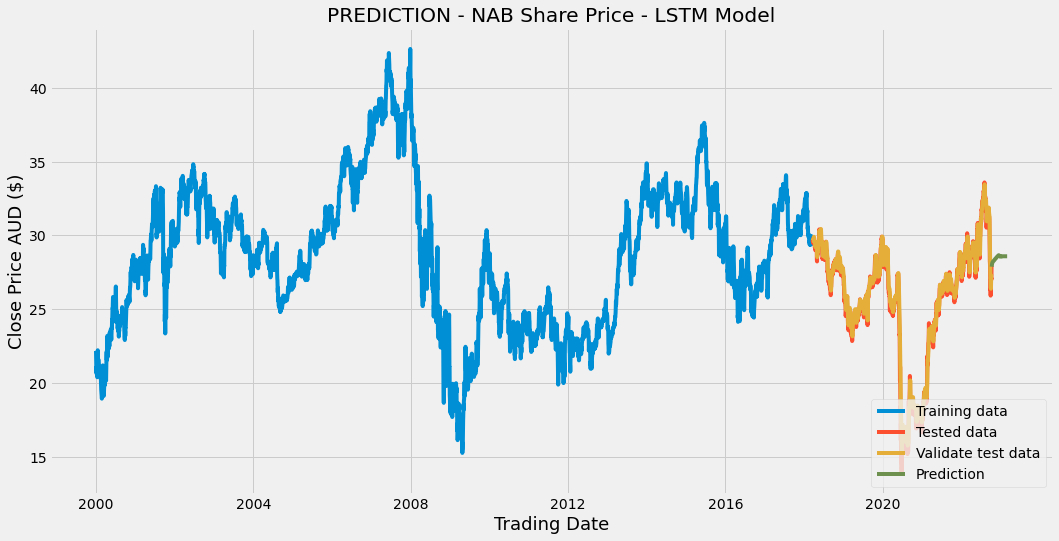

In [92]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION - NAB Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_predict_graph.png')
plt.show()

#Save predicted error to MongoDB

In [93]:
# Module used to connect Python with MongoDb
import pymongo

In [94]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [95]:
# Query all
companys = db.find()
# Iterate through each company in the collection
for company in companys:
    print(company)

# Here, db.companys refers to the collection 'companys '
# company_nab = db.find_one({'name': 'NAB'})
# print(company_nab)


{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10867}
{'_id': ObjectId('62bea6cc0994fe23ecdfe680'), 'model': 'RFR', 'name': 'WBC', 'date': '23/06/2022', 'predicted': 31, 'actual': 19, 'differece': 12.953687103041862, 'accuracy': 97.11}
{'_id': ObjectId('62beab2114d4a8bdddf85ec3'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.076865284173

In [96]:
# Delete a document from a collection
db.delete_one(
    {'name': 'NAB'}
)

# query the companys collection
companys = db.find()
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10867}
{'_id': ObjectId('62bea6cc0994fe23ecdfe680'), 'model': 'RFR', 'name': 'WBC', 'date': '23/06/2022', 'predicted': 31, 'actual': 19, 'differece': 12.953687103041862, 'accuracy': 97.11}
{'_id': ObjectId('62beab2114d4a8bdddf85ec3'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.076865284173

In [97]:
# Set keys and values of company
name = 'NAB'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, rmse {round(rmse,5)}')

date 28/06/2022,predicted 27,actual 27, difference 0, rmse 0.16443


In [98]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference,
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62be5c40e95d9c2fd3be8c1f'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 40, 'actual': 42, 'differece': -2, 'rmse': 0.06586}
{'_id': ObjectId('62be7229a83f80add8272115'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 88, 'actual': 93, 'differece': -5, 'rmse': 2.06539}
{'_id': ObjectId('62be73734cebc85c036027db'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 269, 'actual': 274, 'differece': -5, 'rmse': 2.37099}
{'_id': ObjectId('62be74fb286df5ebd4ec3dc5'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 20, 'actual': 19, 'differece': 1, 'rmse': 0.10867}
{'_id': ObjectId('62bea6cc0994fe23ecdfe680'), 'model': 'RFR', 'name': 'WBC', 'date': '23/06/2022', 'predicted': 31, 'actual': 19, 'differece': 12.953687103041862, 'accuracy': 97.11}
{'_id': ObjectId('62beab2114d4a8bdddf85ec3'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.076865284173

In [99]:
# # query the collection
# nabs = db.nab.find()

# # see change in collection
# for nab in nabs:
#     print(nab)